## <span style="color:pink">(SPH6004 Hands-On) Generative model</span>

This hands-on introduces 3 types of commonly used generative models in 2024: <span style="color:green">Variational Autoencoder (VAE)</span>, <span style="color:orange">Generative Adversarial Network (GAN)</span>, and <span style="color:red">Diffusion Probabilistic Models (DDPM)</span>. (**to be updated in future**) Each approach has its own advantages and disadvantages. You will train these models on your own for digit (numbers from 1-10) generation tasks. You may find the task too boring. But believe me, scaling the models introduced here to more fancy tasks such as face, voice or text is fairly straightforward. 

### <span style="color:pink">Prerequisites</span>
This hands-on is certainly not for beginners. I assume you know :
* **Basic Probability Statistics knowledge** (distribution, maximum liklihood estimation, etc) 
* **Deep Neural Network** (CNN backbones and optimization techniques)
* **Python** (especially OOP(Object Oriented Programming) )
* **Pytorch** (Package that offers flexible Neural Network design and training) 
* **Pytorch-lightning** (Package built on top of Pytorch to offer many useful)


Please refer to the lecture notes for insights into the motivation, derivation, and mathematical description of each model.

## Load Packages

In [4]:
import numpy as np
import torch
import pytorch_lightning as pl
import random

from torch.utils.data import DataLoader
from torchvision import transforms as T
from torchvision.datasets import MNIST

import torch.nn.functional as F
from torch import nn
from monai.networks.blocks.dynunet_block import UnetBasicBlock

from itertools import *
from toolz import *
from toolz.curried import *
from toolz.curried.operator import *
from toolz.sandbox.core import unzip


from matplotlib import pyplot as plt

from torch.optim import Adam

### Dataset
we are using MNIST dataset.
* No random data augumentation is applied here. Try adding some complicated augmentation techniques for better generation quality.
* image is resized to 32 by 32 to enable 2 by 2 pooling 5 times.
* image is normalized to have zero mean and varance 1 for more stable training.

In [5]:
mnist = MNIST(
    "../data",
    train=True,
    download=True,
    transform=T.Compose(
        [
            T.Resize((32, 32)),
            T.ToTensor(),
            T.Normalize(mean=[0.5], std=[0.5]),
        ],
    ),
)

mnist_loader = torch.utils.data.DataLoader(
    mnist,
    batch_size=256,  # increase this for faster training if you are running this in a better server
    num_workers=8,  # increase this for faster training if you are running this in a better server
    pin_memory=True,
    shuffle=True,
)

### Define fuctions that will be used troughout this hands-on.

1. image visualizer
2. encoder
3. decoder

In [6]:
def vis_batch(
    batch,
    num_images=10,
    include_labels=True,
    title="",
):

    fig, axes = plt.subplots(ncols=num_images, figsize=(num_images * 2, 1 * 3))
    for ax, (img, lab) in zip(axes, compose(take(num_images), unzip)(batch)):
        img = ((img + 1) / 2)[0, ...]
        ax.imshow(img)
        ax.axis("off")
        if include_labels:
            ax.set_title(f"label: {lab}")
    plt.suptitle(title, fontsize=30)
    plt.show()


class Encoder(nn.Sequential):
    def __init__(self, in_channes=1, out_channels=128):
        super().__init__(
            nn.Conv2d(in_channes, in_channes * 1, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channes * 1, in_channes * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(in_channes * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channes * 2, in_channes * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(in_channes * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channes * 4, in_channes * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(in_channes * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channes * 8, out_channels, 4, 2, 1, bias=False),
        )


class Decoder(nn.Sequential):
    def __init__(self, in_channes=128, out_channels=1):
        super().__init__(
            nn.ConvTranspose2d(
                in_channes,
                in_channes // 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(in_channes // 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                in_channes // 2,
                in_channes // 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(in_channes // 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                in_channes // 4,
                in_channes // 8,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(in_channes // 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                in_channes // 8,
                in_channes // 16,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(in_channes // 16),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                in_channes // 16,
                out_channels,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
        )

## VAE

In [7]:
class VAE(pl.LightningModule):
    def __init__(
        self,
        input_spatial_size=[32, 32],
        num_classes=10,
        feature_size=128,
        mu_sigma_size=128,
    ):
        super().__init__()

        self.input_spatial_size = input_spatial_size
        self.feature_size = feature_size
        self.mu_sigma_size = mu_sigma_size
        self.num_classes = num_classes

        self.encoder = Encoder()
        self.decoder = nn.Sequential(Decoder(), nn.Tanh())
        self.to_mu = nn.Conv2d(feature_size, mu_sigma_size, 1)
        self.to_sigma = nn.Sequential(
            nn.Conv2d(feature_size, mu_sigma_size, 1), nn.Softplus()
        )
        self.map_label = nn.Conv2d(self.num_classes, mu_sigma_size, 1)

    def forward(self, batch):

        x, y = batch
        y = F.one_hot(y, num_classes=self.num_classes)
        y = y.to(torch.float)[..., None, None]

        e_x = self.encoder(x)

        mu_z = self.to_mu(e_x)
        sigma_z = self.to_sigma(e_x)
        emb_y = self.map_label(y)
        noise = torch.randn_like(mu_z).to(x.device)
        z = (noise + mu_z) * (sigma_z) + emb_y

        x_hat = self.decoder(z)

        return x_hat, mu_z, sigma_z

    def compute_kl(self, mu, sigma):

        mu = mu.flatten(1)
        sigma = sigma.flatten(1)

        return 0.5 * (
            torch.pow(mu, 2)
            + torch.pow(sigma, 2)
            - torch.log(1e-8 + torch.pow(sigma, 2))
            - 1
        ).sum(-1).mean(0)

    def training_step(self, batch, batch_idx):

        x, y = batch

        x_hat, mu_z, sigma_z = self(batch)
        mse = (
            nn.functional.mse_loss(x_hat, x)
            * self.input_spatial_size[0]
            * self.input_spatial_size[1]
        )
        kl = self.compute_kl(mu_z, sigma_z)

        loss = mse + kl
        self.log(
            "total_loss", loss, prog_bar=True, logger=True, on_step=True, on_epoch=True
        )

        return loss

    def on_train_epoch_end(self):

        x_hats = []
        labs = []
        for _ in range(10):
            x_hat, lab = self.sample()
            x_hats.append(x_hat.detach().cpu())
            labs.append(lab)
        vis_batch((torch.cat(x_hats), labs))

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=1e-4)
        return optimizer

    def sample(self, condition=None):

        if condition == None:
            _lab = random.randint(0, self.num_classes - 1)
        else:
            _lab = condition

        lab = (
            torch.tensor(F.one_hot(torch.tensor(_lab), num_classes=self.num_classes))
            .to(torch.float32)
            .to(self.device)[..., None, None]
        )

        z = torch.randn(self.mu_sigma_size).to(self.device)[None, ..., None, None]

        z = z + self.map_label(lab)

        x_hat = self.decoder(z)

        return (x_hat, _lab)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Encoder    | 17.1 K
1 | decoder   | Sequential | 174 K 
2 | t

Training: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_1882322/1856511702.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(F.one_hot(torch.tensor(_lab), num_classes=self.num_classes))


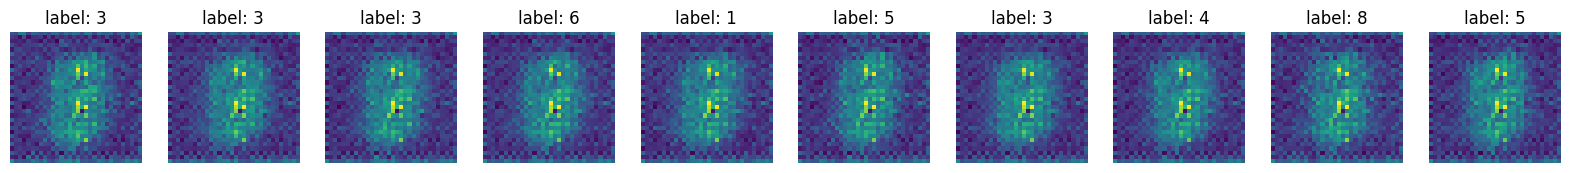

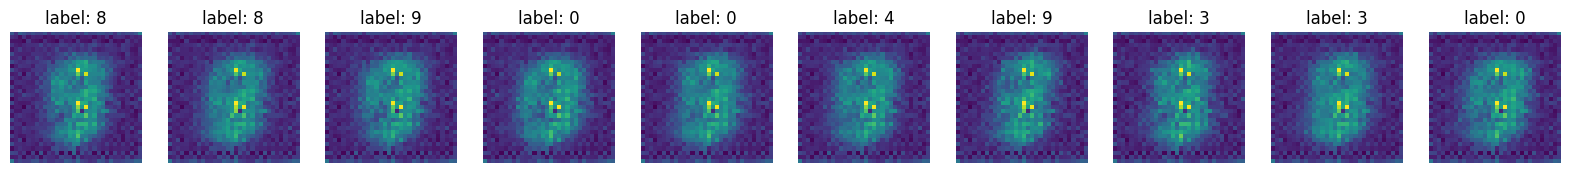

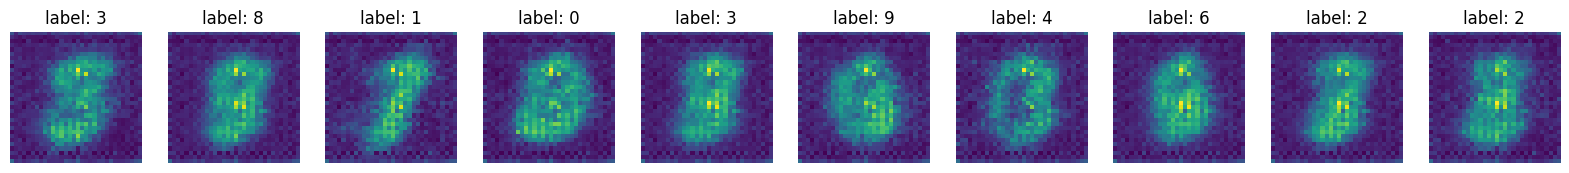

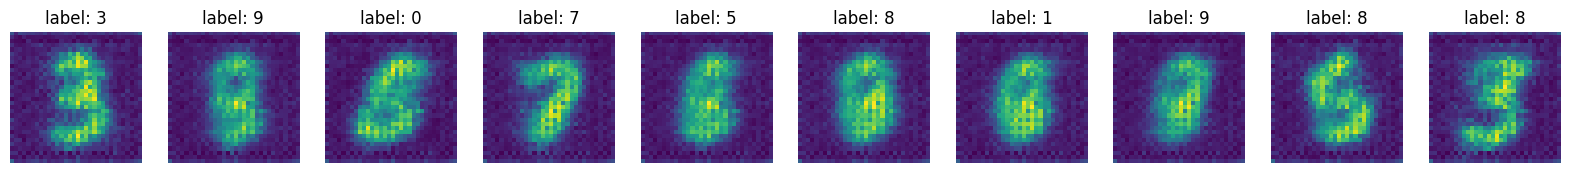

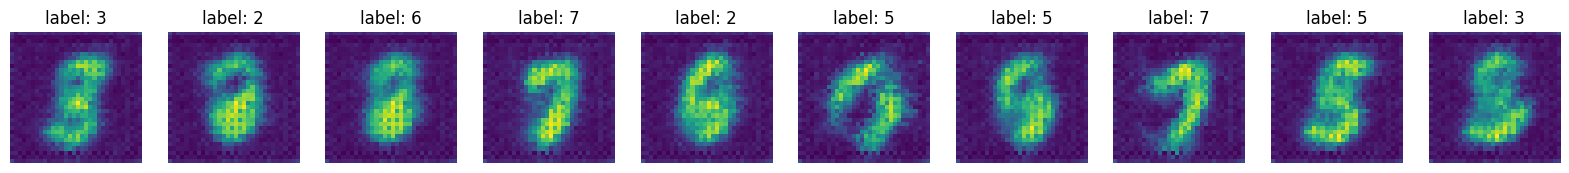

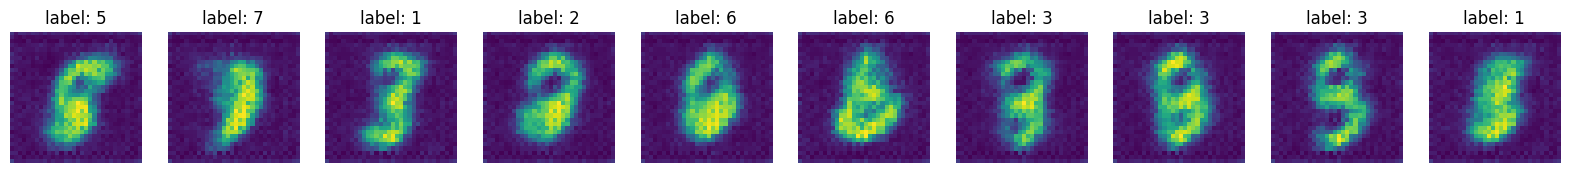

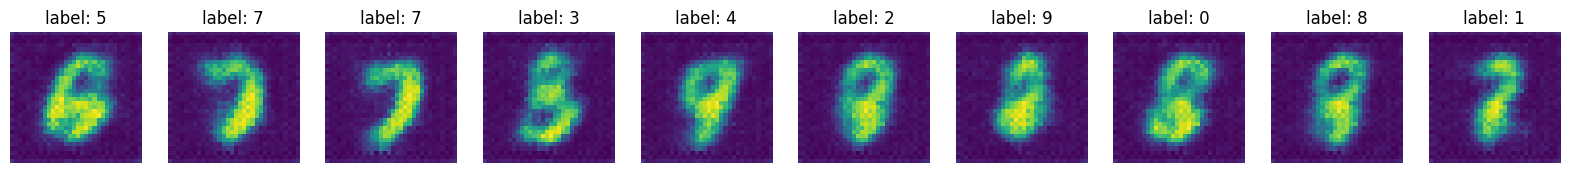

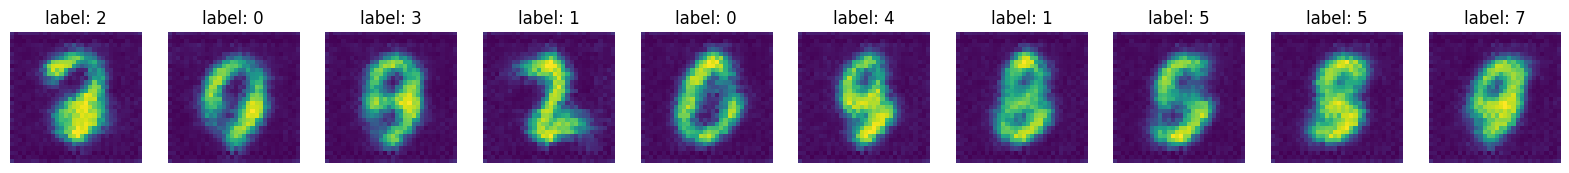

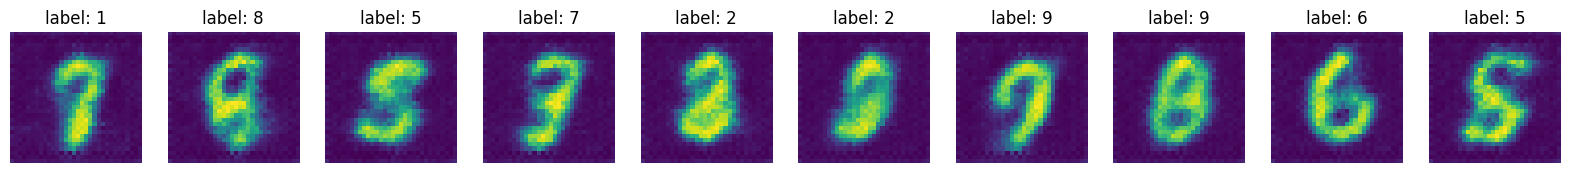

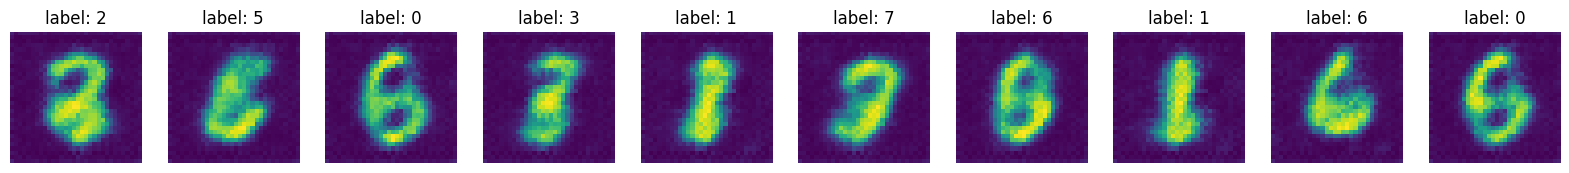

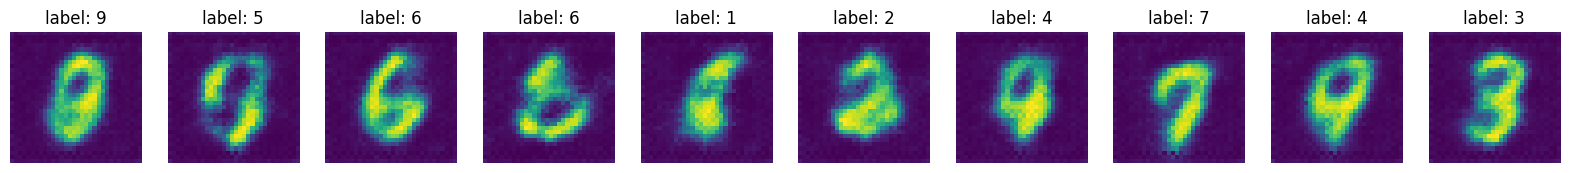

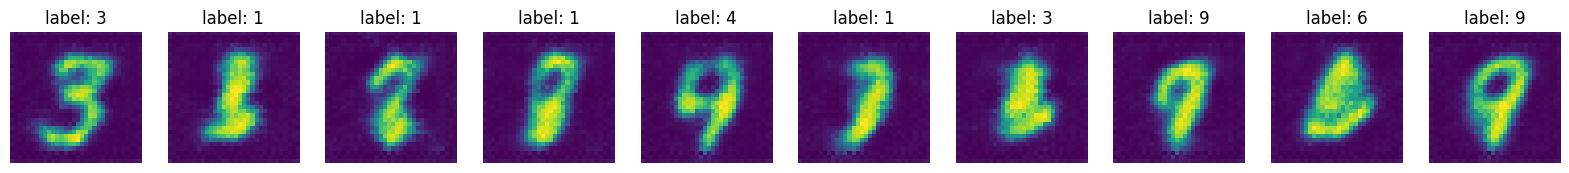

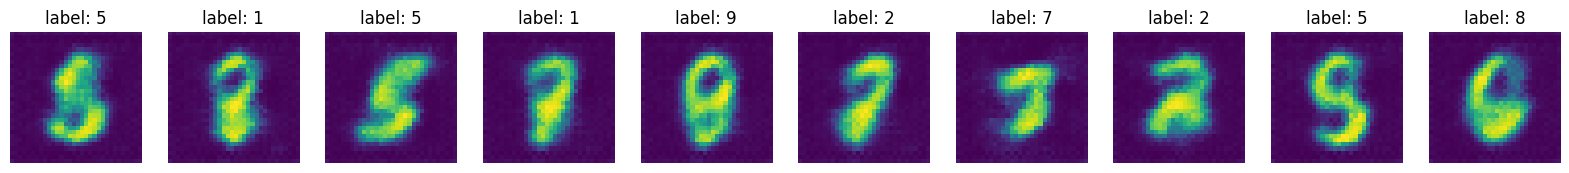

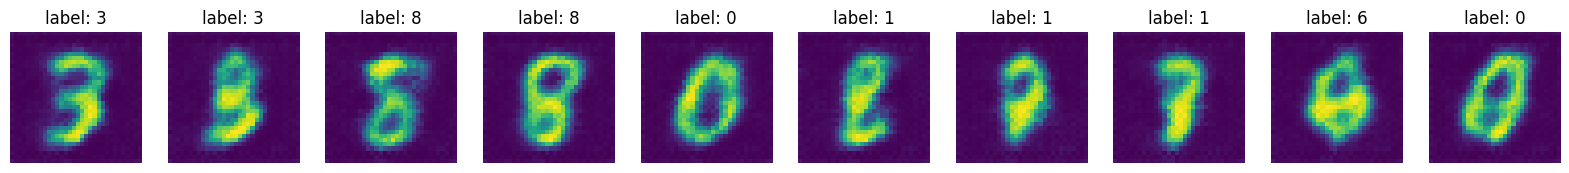

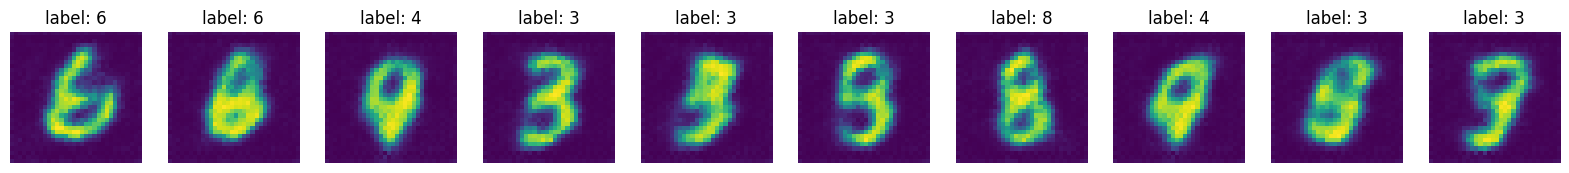

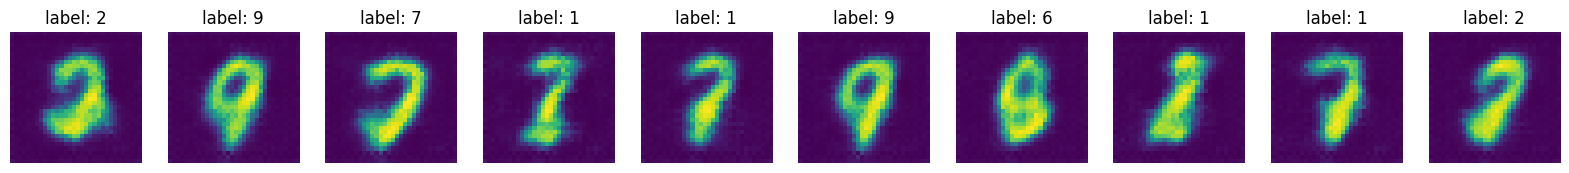

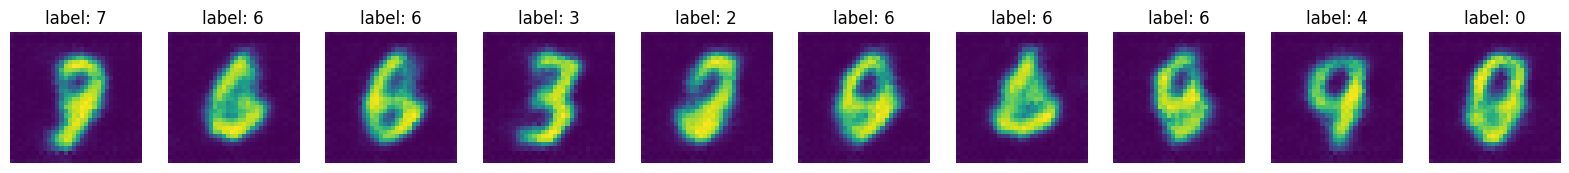

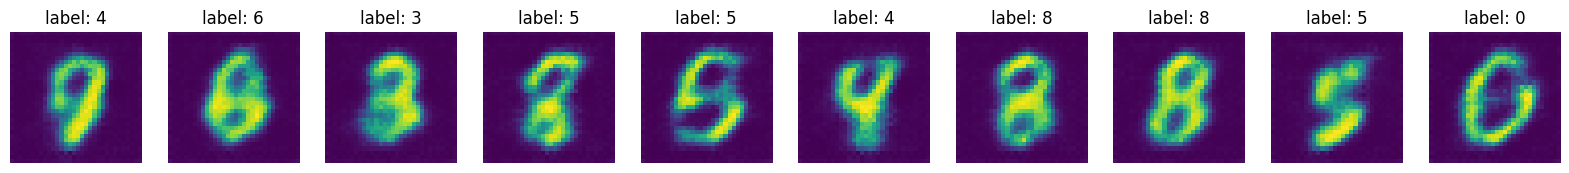

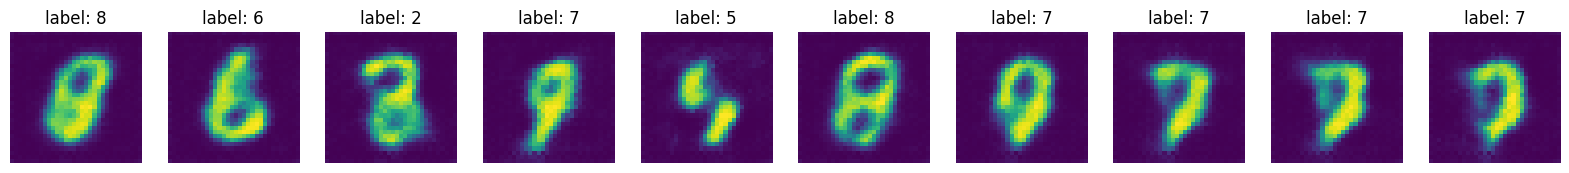

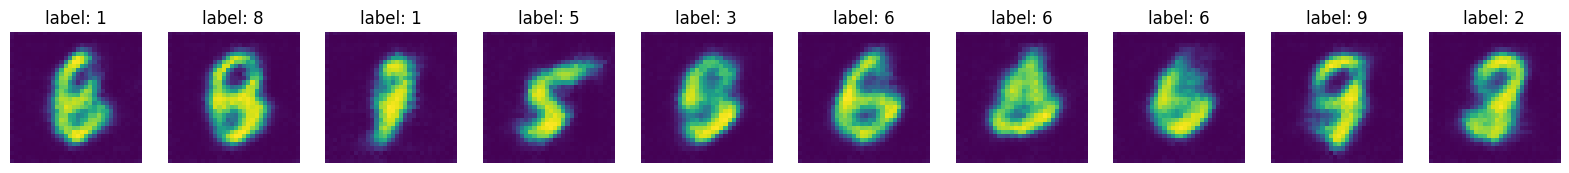

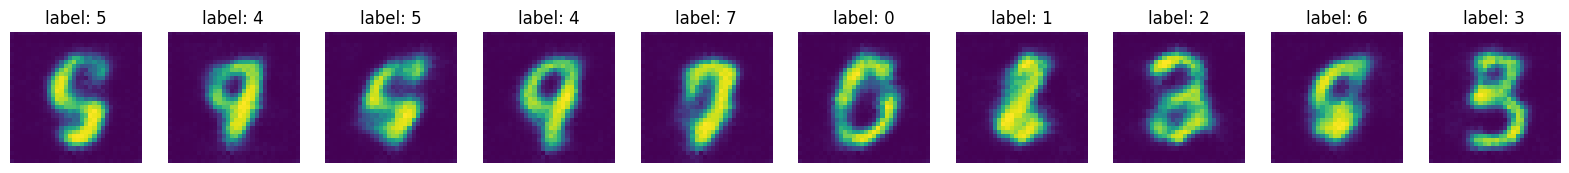

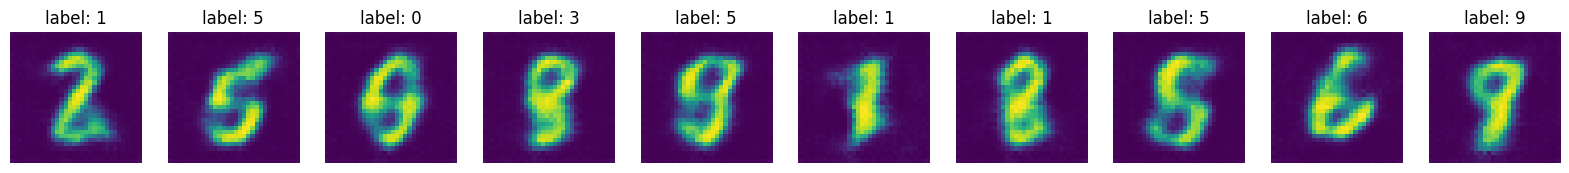

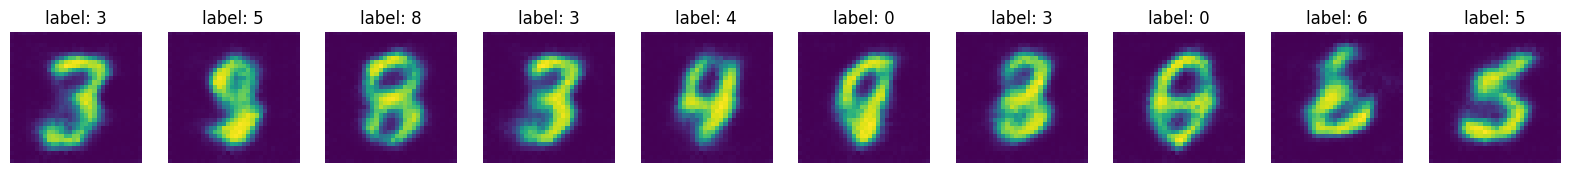

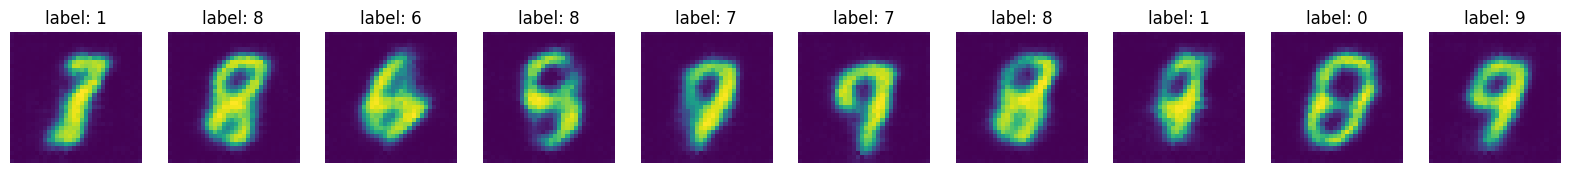

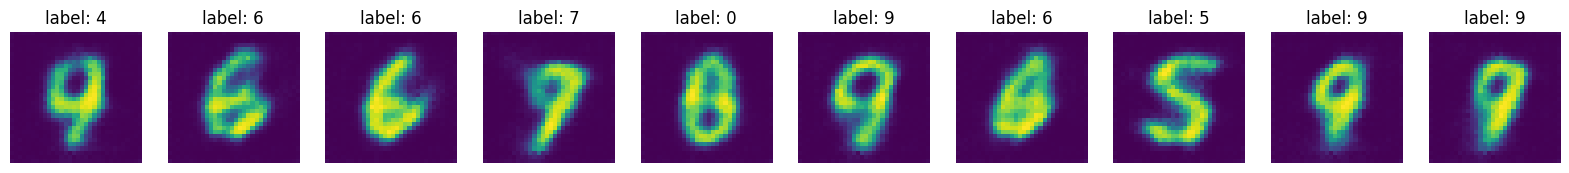

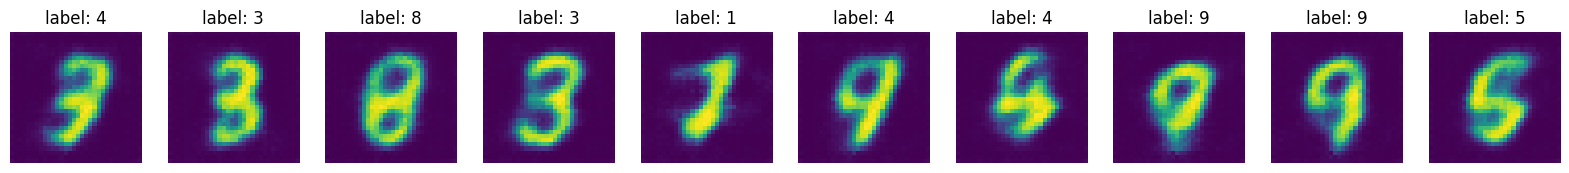

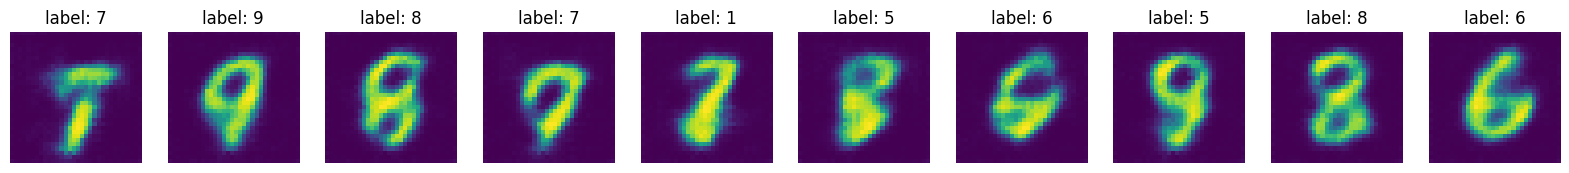

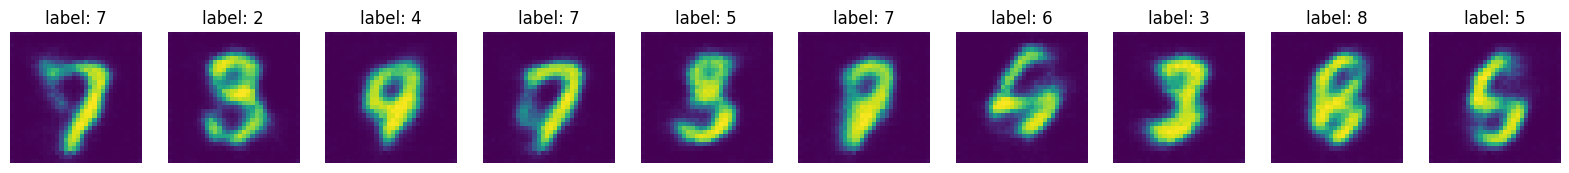

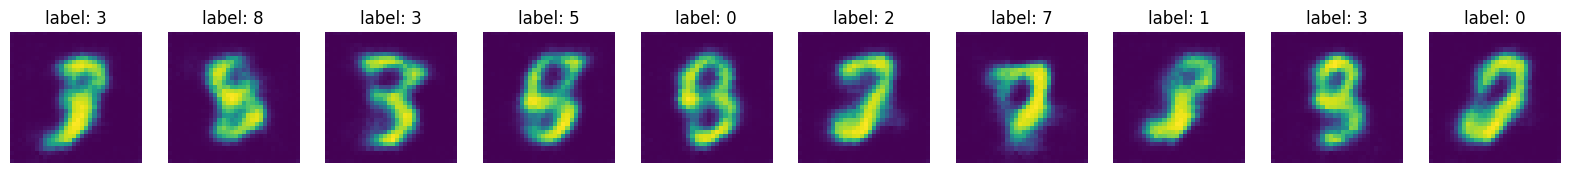

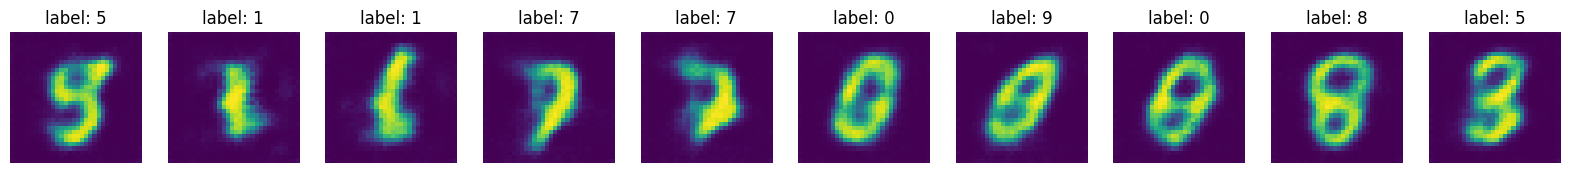

`Trainer.fit` stopped: `max_epochs=30` reached.


In [8]:
trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=30,
    enable_checkpointing=False,
    logger=False,
)  # try increasing the epoch size for better result
vae = VAE()
trainer.fit(model=vae, train_dataloaders=mnist_loader)

## GAN

In [9]:
class GAN(pl.LightningModule):
    def __init__(
        self,
        input_spatial_size=[32, 32],
        num_classes=10,
        feature_size=128,
    ):
        super().__init__()

        self.input_spatial_size = input_spatial_size
        self.feature_size = feature_size
        self.num_classes = num_classes

        self.generator = nn.Sequential(
            Decoder(in_channes=feature_size + num_classes), nn.Tanh()
        )
        self.discriminator = nn.Sequential(
            Encoder(in_channes=1 + num_classes), nn.Conv2d(feature_size, 1, 1)
        )

        self.automatic_optimization = False

    def training_step(self, batch, batch_idx):

        optimizer_g, optimizer_d = self.optimizers()

        x, y = batch
        y = F.one_hot(y, num_classes=self.num_classes)
        y = y.to(torch.float)[..., None, None]

        ones = torch.ones(x.shape[0], 1, 1, 1).to(x.device)  # real
        zeros = torch.zeros(x.shape[0], 1, 1, 1).to(x.device)  # fake

        self.toggle_optimizer(optimizer_g)

        z = torch.randn(x.shape[0], self.feature_size)[..., None, None].to(x.device)
        g_loss = F.binary_cross_entropy_with_logits(
            self.discriminator(
                torch.cat(
                    [
                        self.generator(torch.cat([z, y], axis=1)),
                        y.repeat(1, 1, *self.input_spatial_size),
                    ],
                    axis=1,
                )
            ),
            ones,
        )
        self.manual_backward(g_loss)
        optimizer_g.step()
        optimizer_g.zero_grad()
        self.untoggle_optimizer(optimizer_g)
        self.log(
            "g_loss", g_loss, prog_bar=True, logger=True, on_step=True, on_epoch=True
        )

        self.toggle_optimizer(optimizer_d)

        real_loss = F.binary_cross_entropy_with_logits(
            self.discriminator(
                torch.cat([x, y.repeat(1, 1, *self.input_spatial_size)], axis=1)
            ),
            ones,
        )

        fake_loss = F.binary_cross_entropy_with_logits(
            self.discriminator(
                torch.cat(
                    [
                        self.generator(torch.cat([z, y], axis=1)),
                        y.repeat(1, 1, *self.input_spatial_size),
                    ],
                    axis=1,
                )
            ),
            zeros,
        )

        d_loss = (real_loss + fake_loss) / 2

        self.manual_backward(d_loss)
        optimizer_d.step()
        optimizer_d.zero_grad()
        self.untoggle_optimizer(optimizer_d)

        self.log(
            "d_loss", d_loss, prog_bar=True, logger=True, on_step=True, on_epoch=True
        )

    def on_train_epoch_end(self):
        x_hats = []
        labs = []
        for _ in range(10):
            x_hat, lab = self.sample()
            x_hats.append(x_hat.detach().cpu())
            labs.append(lab)
        vis_batch((torch.cat(x_hats), labs))

    def configure_optimizers(self):
        optimizer_g = Adam(
            self.generator.parameters(),
            lr=0.0002,
            betas=(0.5, 0.999),
        )
        optimizer_d = Adam(
            self.discriminator.parameters(),
            lr=0.0002,
            betas=(0.5, 0.999),
        )
        return [optimizer_g, optimizer_d]

    def sample(self, condition=None):

        if condition == None:
            _lab = random.randint(0, self.num_classes - 1)
        else:
            _lab = condition

        lab = (
            torch.tensor(F.one_hot(torch.tensor(_lab), num_classes=self.num_classes))
            .to(torch.float32)
            .to(self.device)[None, ..., None, None]
        )

        z = torch.randn(self.feature_size).to(self.device)[None, ..., None, None]
        x_hat = self.generator(torch.cat([z, lab], axis=1))
        return (x_hat, _lab)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name          | Type       | Params
---------------------------------------------
0 | generator     | Sequential | 201 K 
1 | discriminator | Sequential | 263 K 
---------------------------------------------
465 K     Trainable params
0         Non-trainable params
465 K     Total params
1.862     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

/home/jacob/.pyenv/versions/miniconda3-3.11-23.5.0-3/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('g_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/jacob/.pyenv/versions/miniconda3-3.11-23.5.0-3/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('d_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/tmp/ipykernel_1882322/3908626686.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(F.one_hot(torch.tensor(_lab), num_classes=self.num_classes))


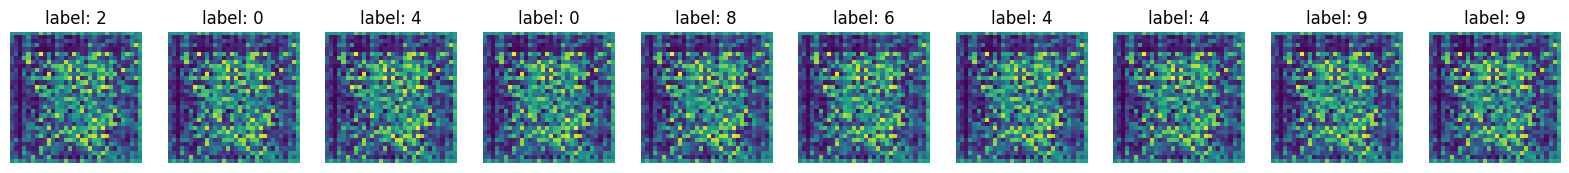

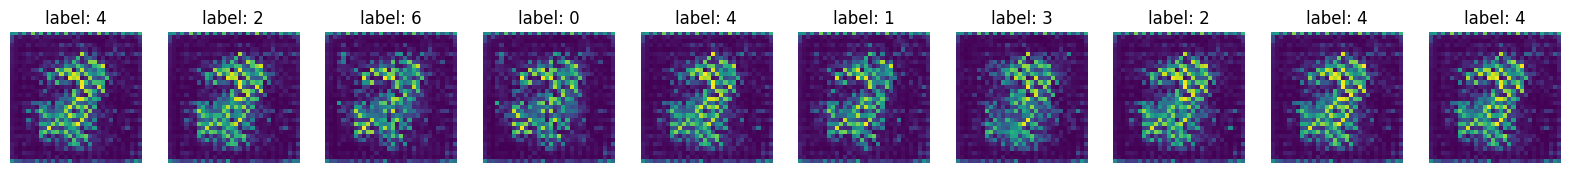

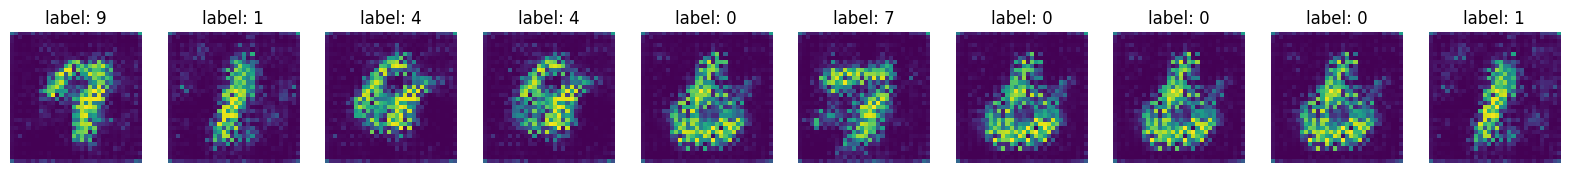

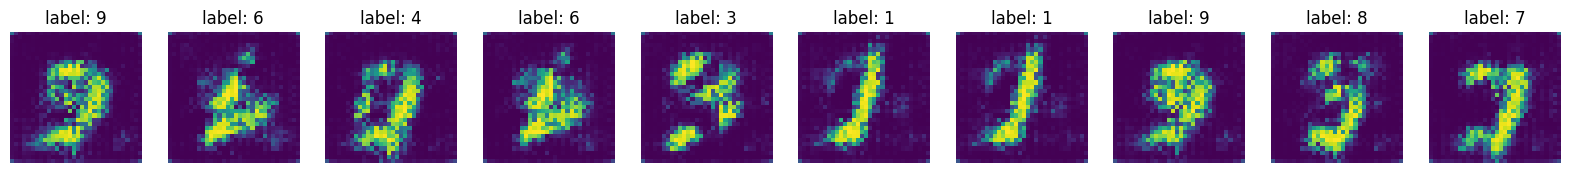

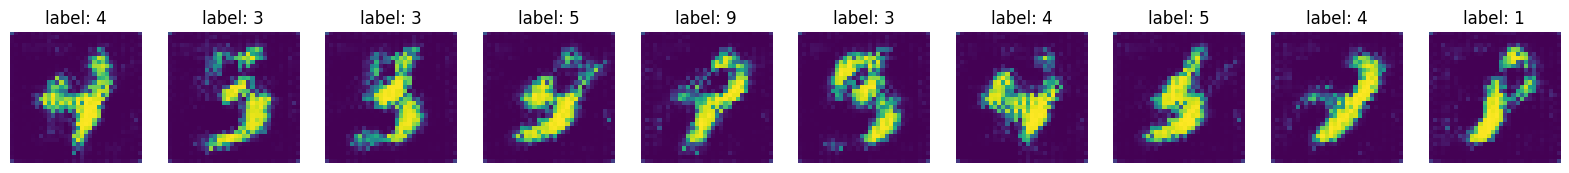

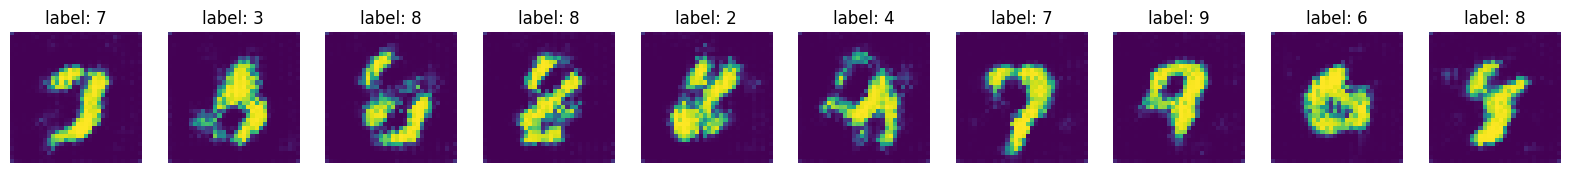

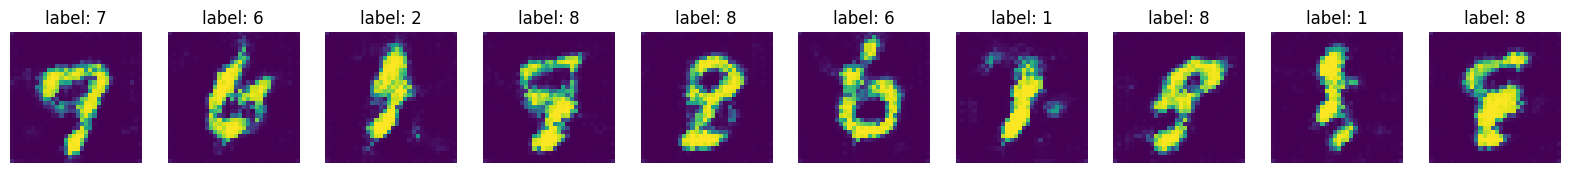

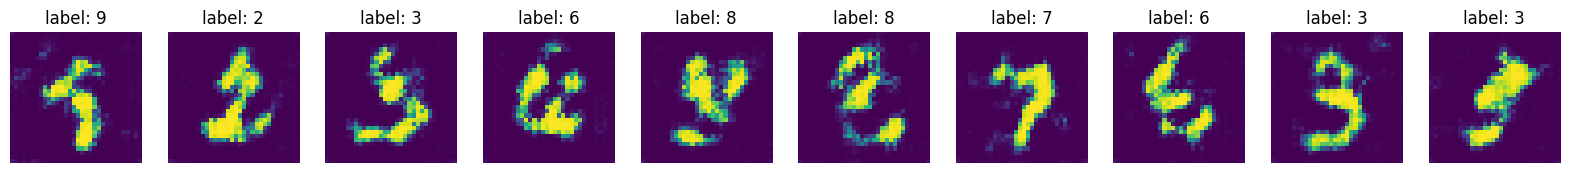

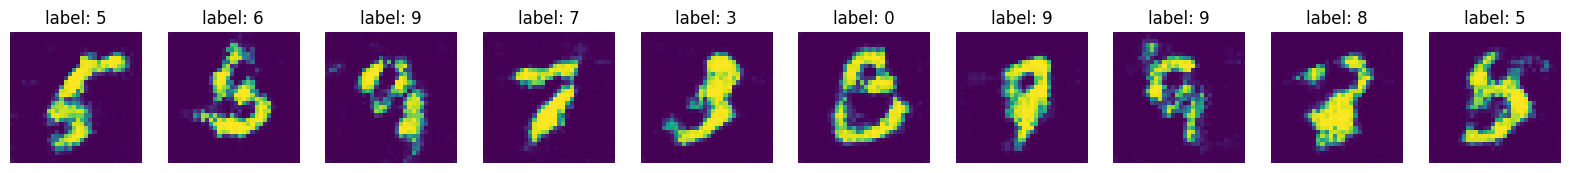

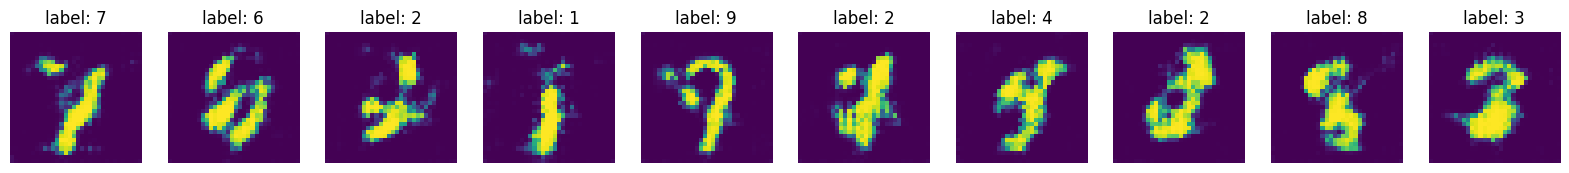

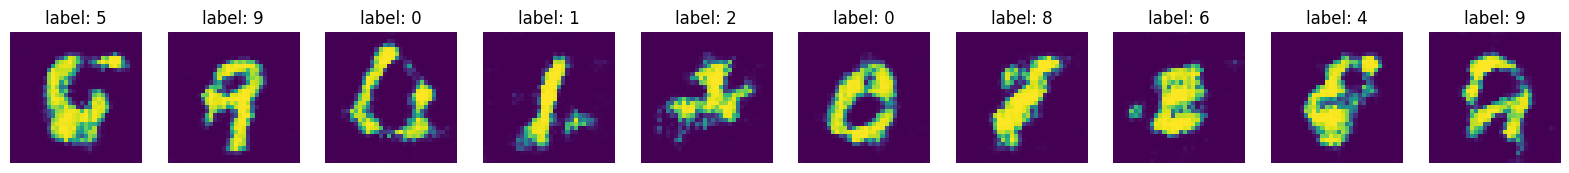

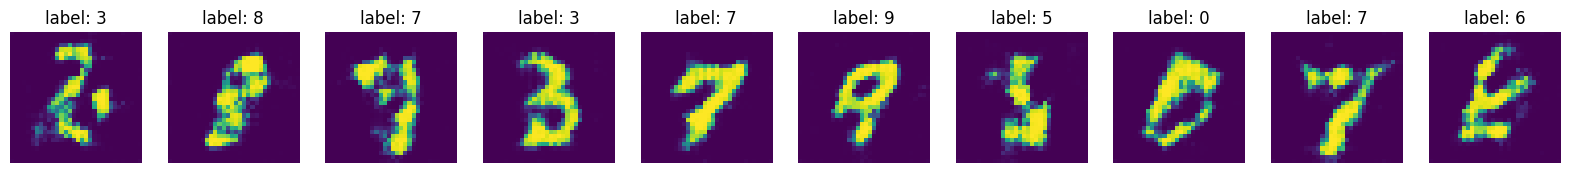

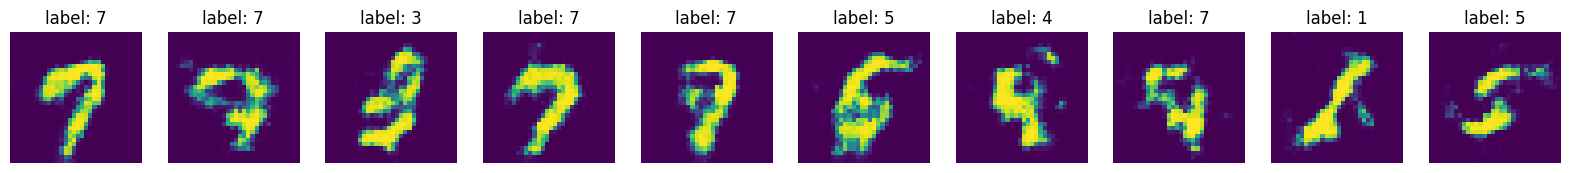

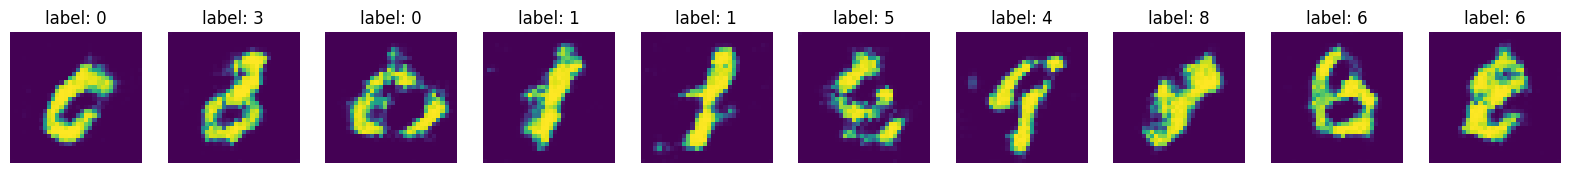

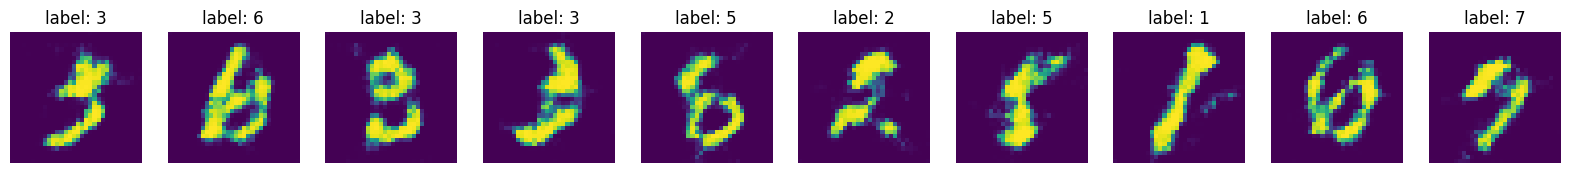

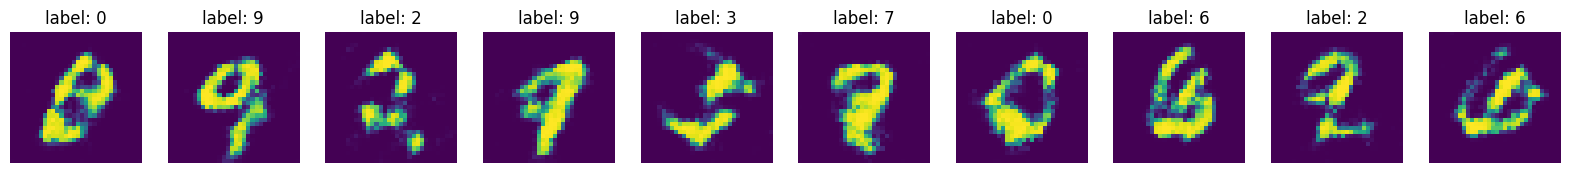

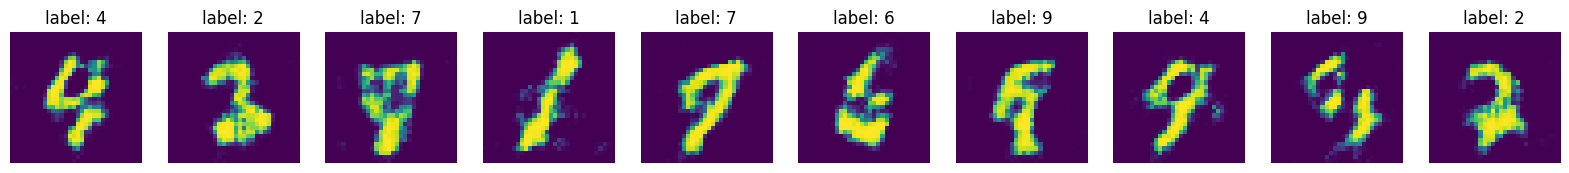

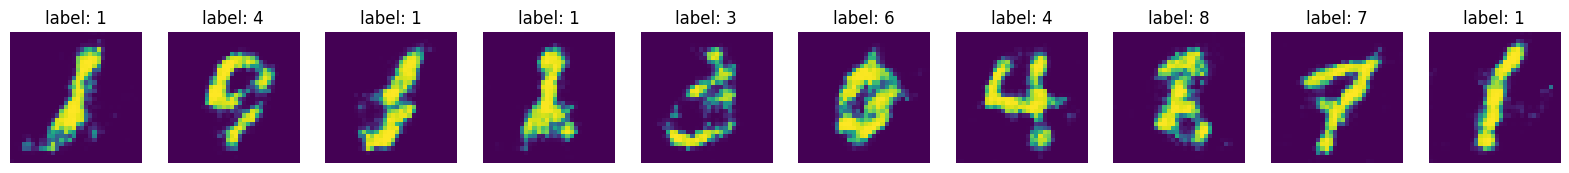

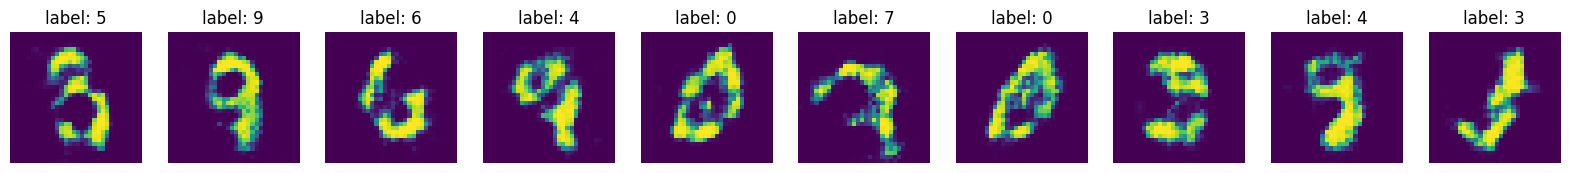

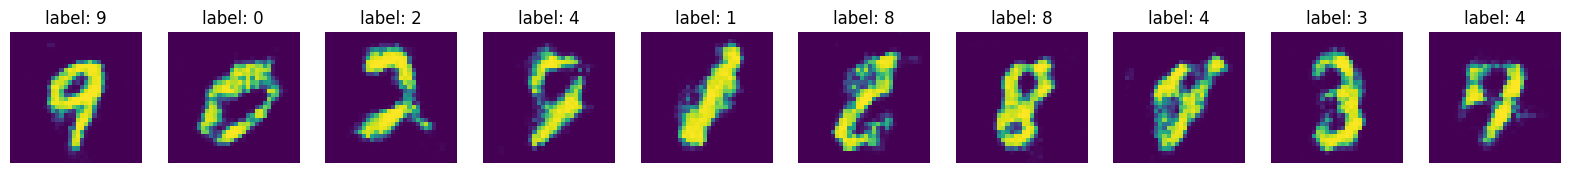

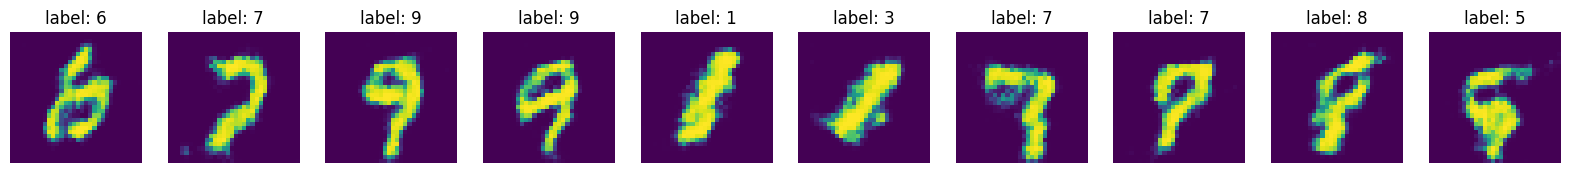

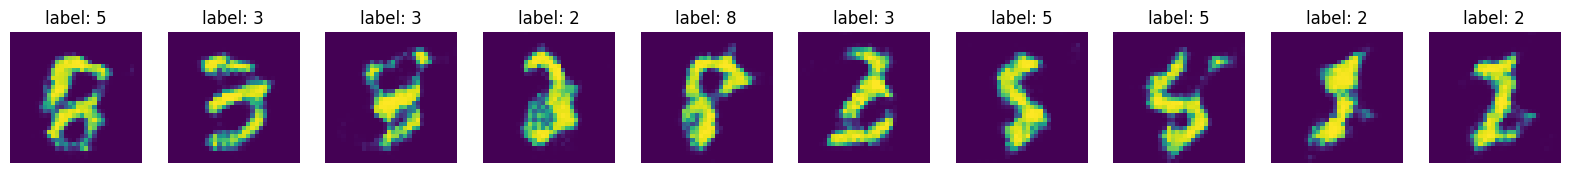

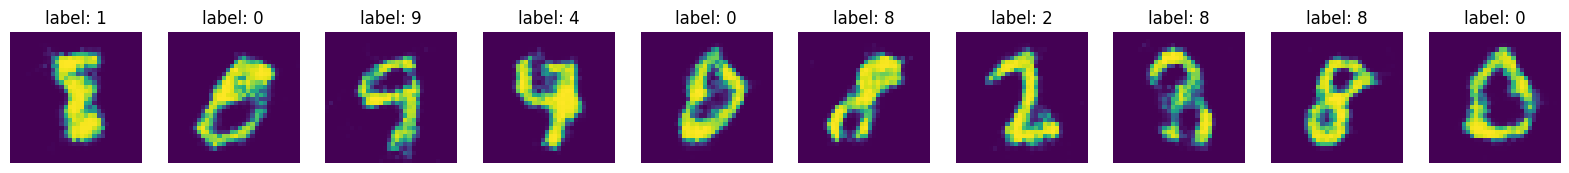

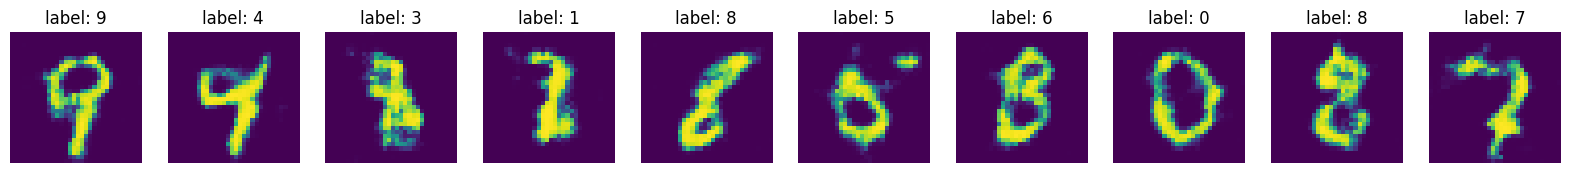

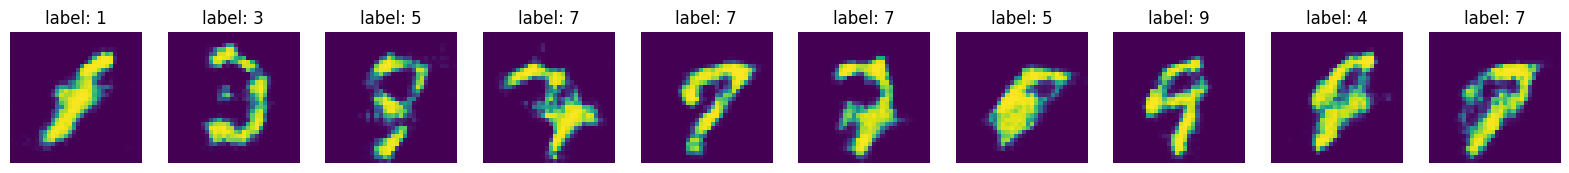

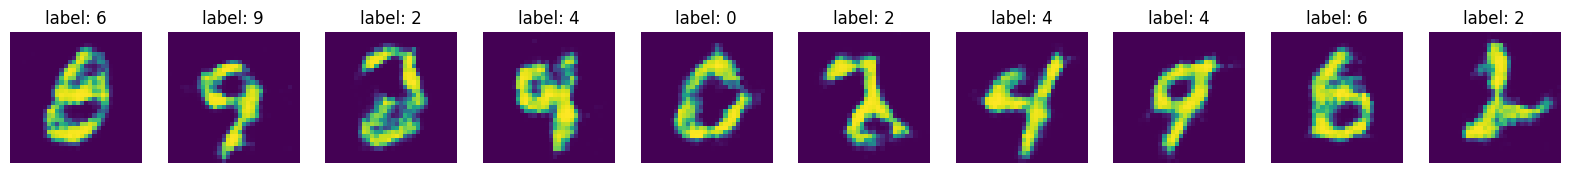

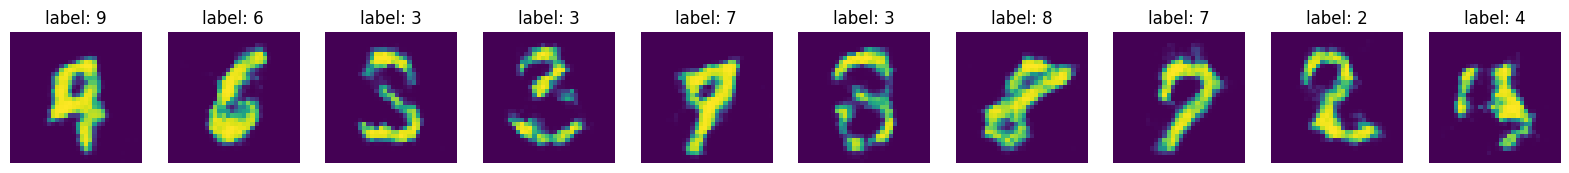

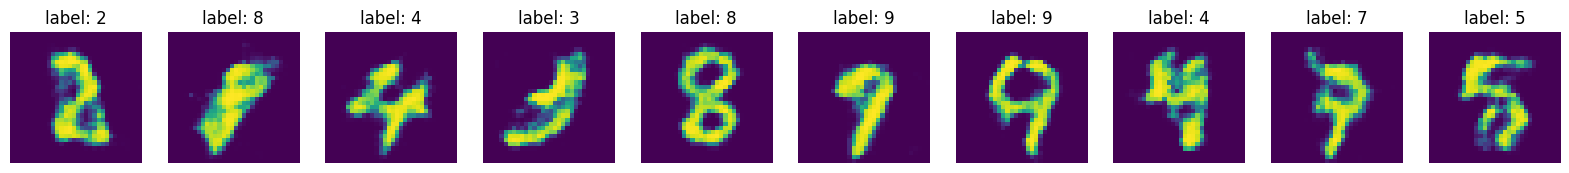

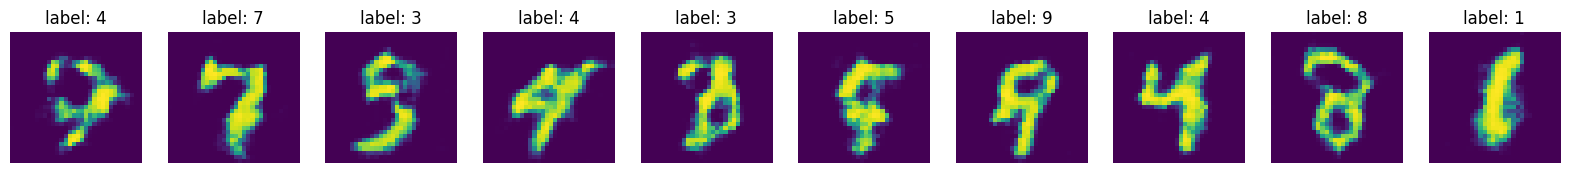

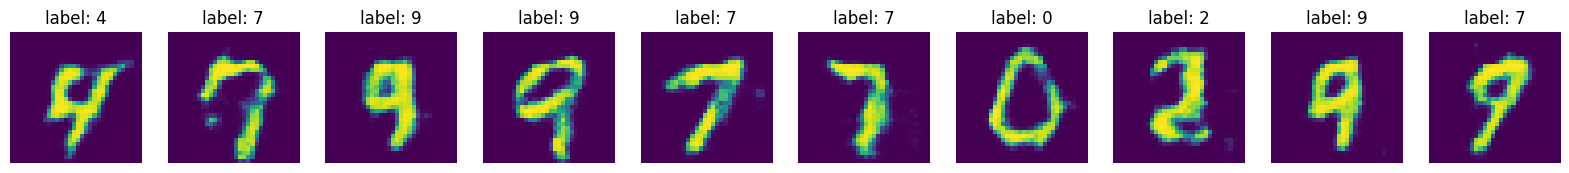

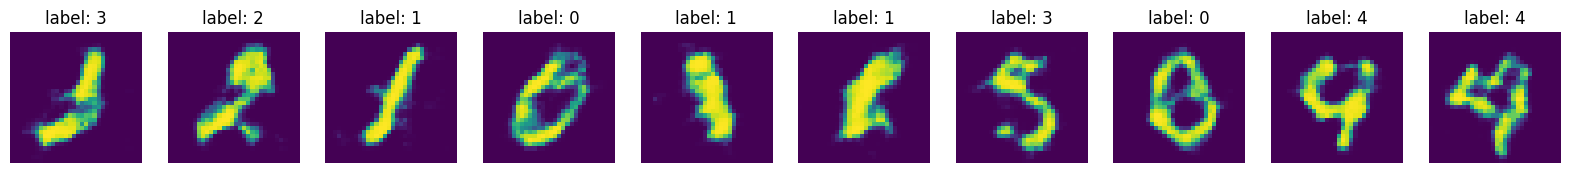

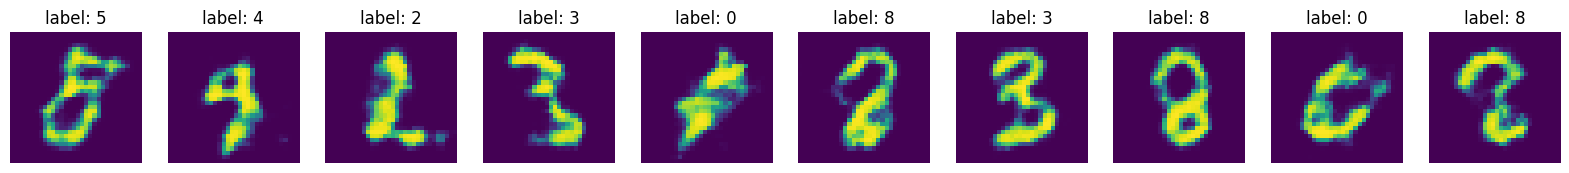

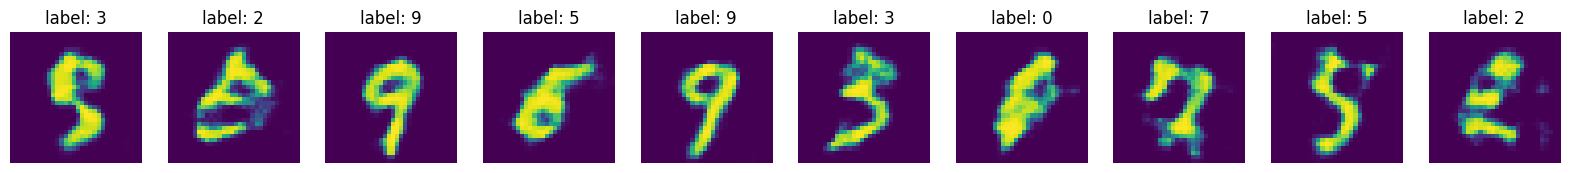

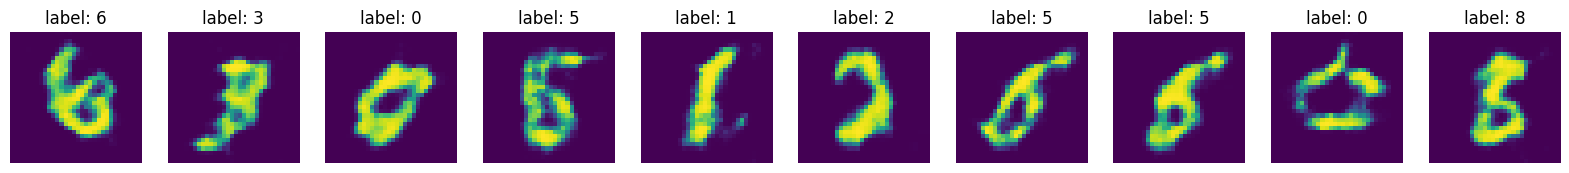

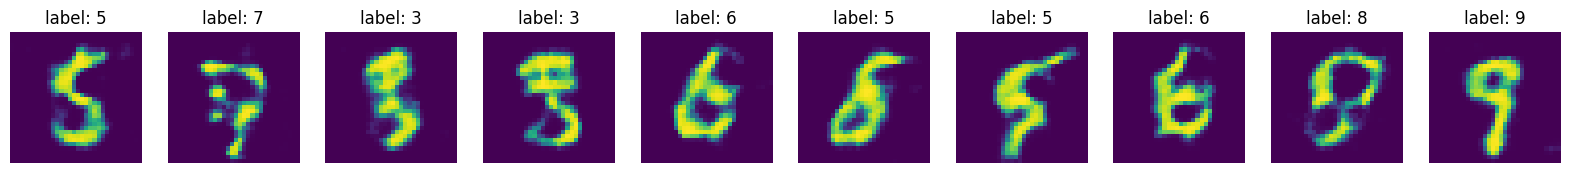

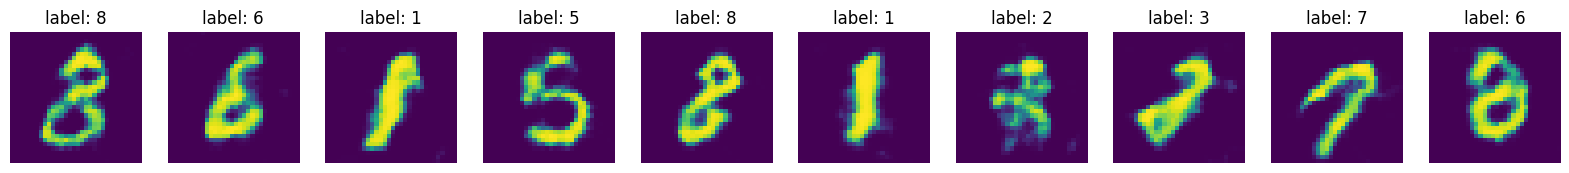

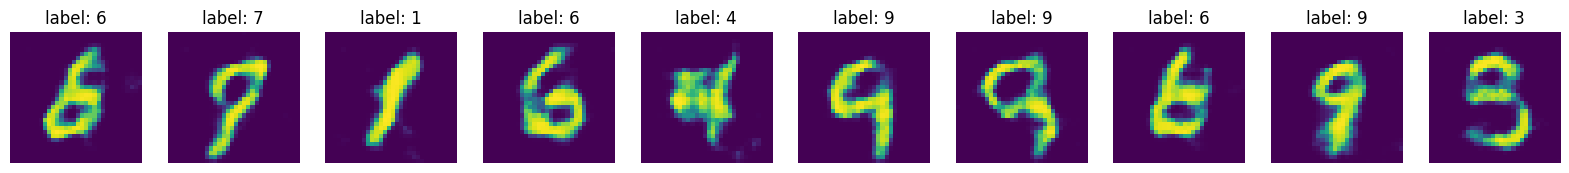

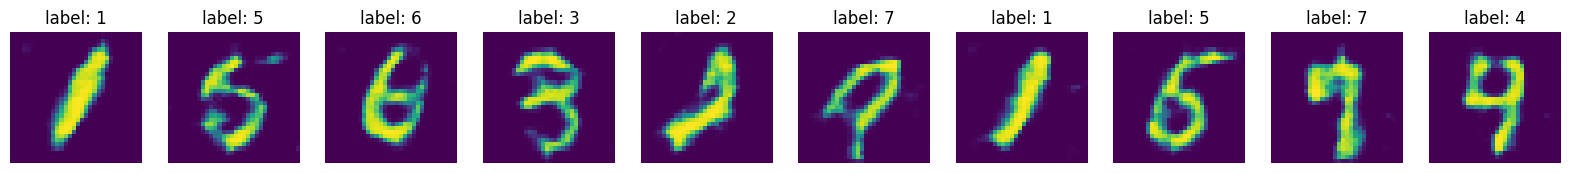

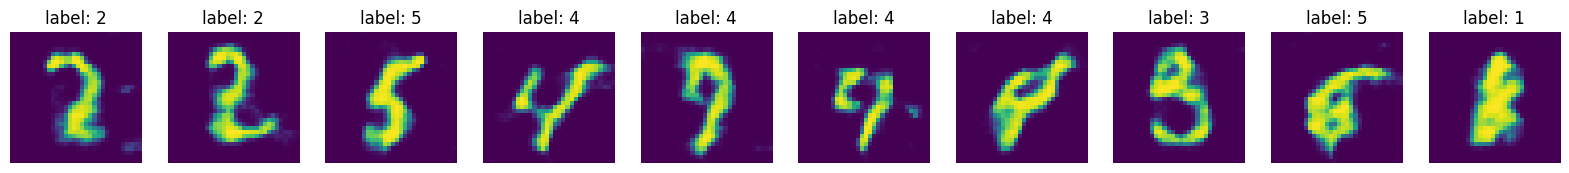

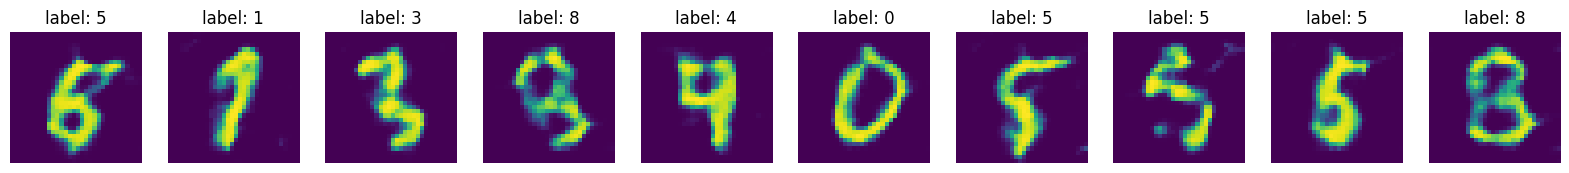

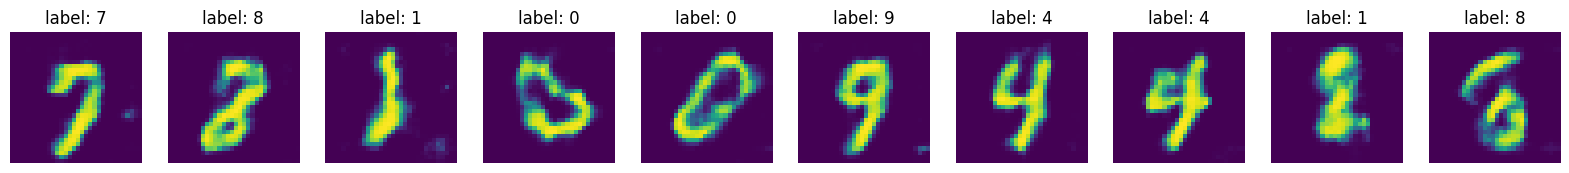

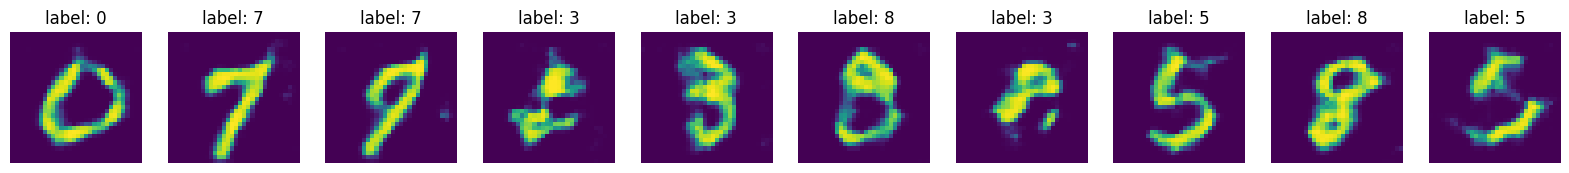

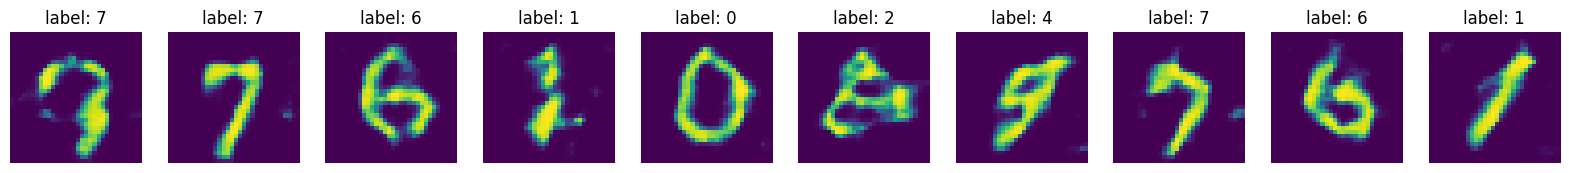

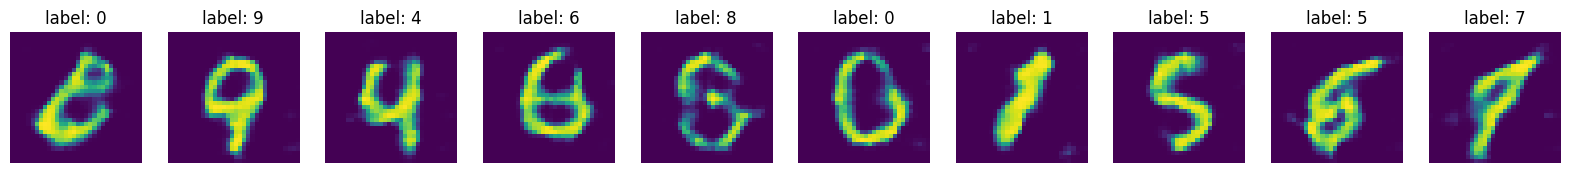

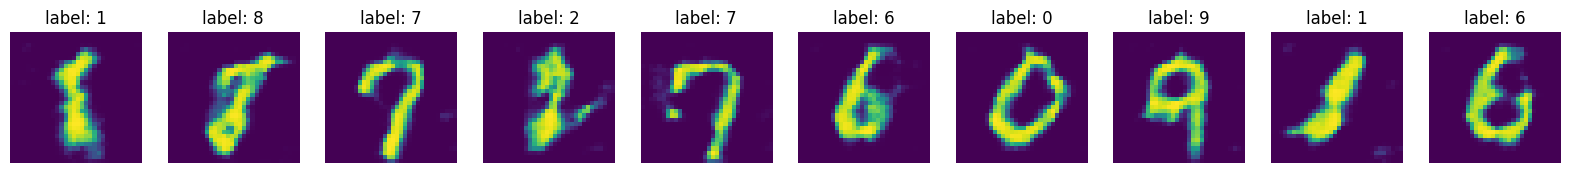

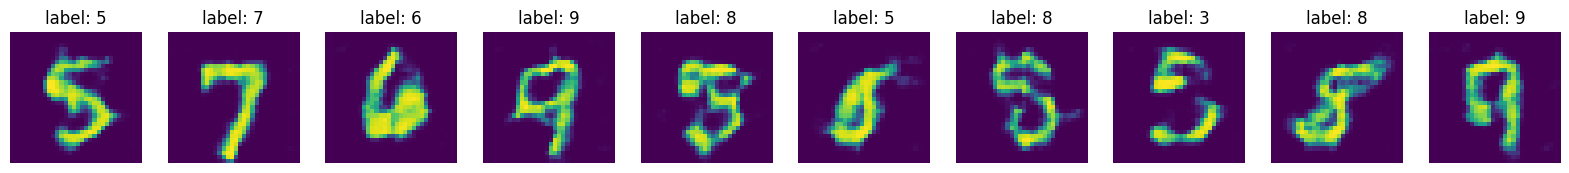

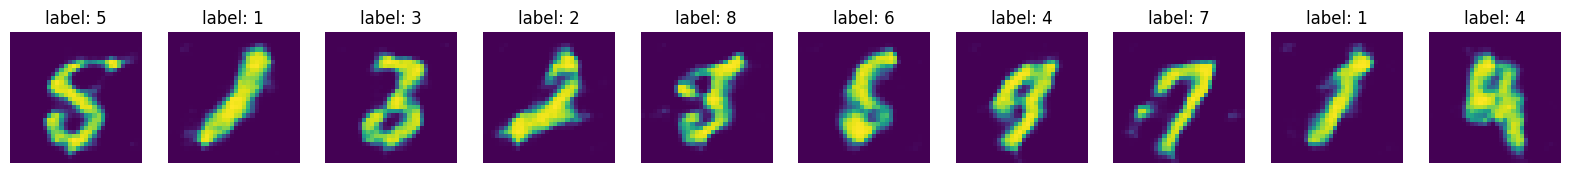

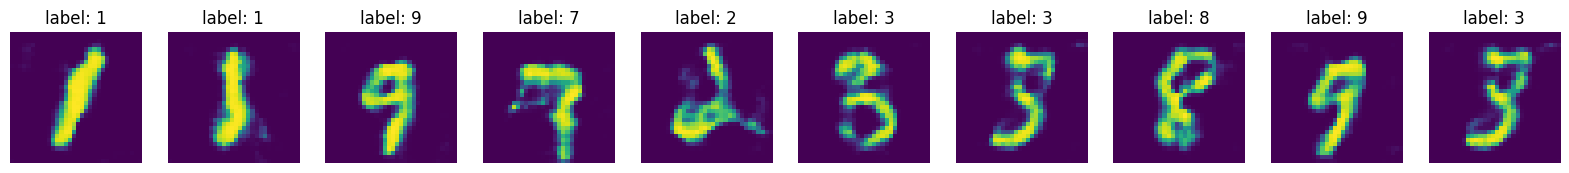

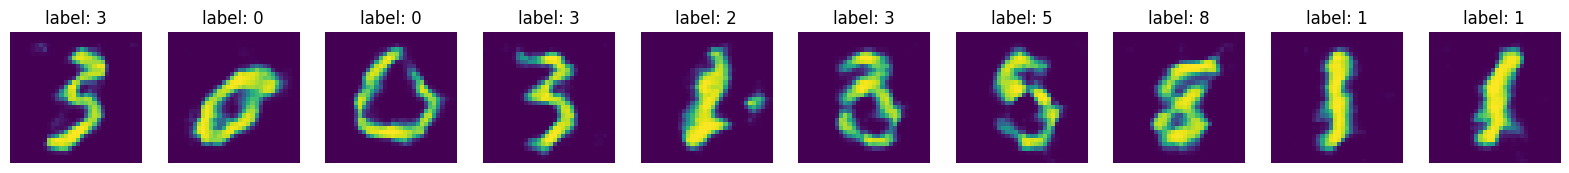

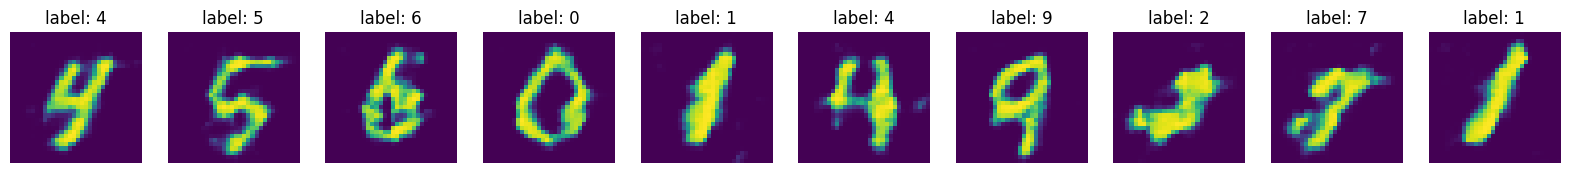

`Trainer.fit` stopped: `max_epochs=50` reached.


In [12]:
trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=30,
    enable_checkpointing=False,
    logger=False,
)
gan = GAN()
trainer.fit(model=gan, train_dataloaders=mnist_loader)

## DDPM 
to be updated

## Test each model

Now we have trained models. Try generting digits you want.

/tmp/ipykernel_1882322/1856511702.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(F.one_hot(torch.tensor(_lab), num_classes=self.num_classes))


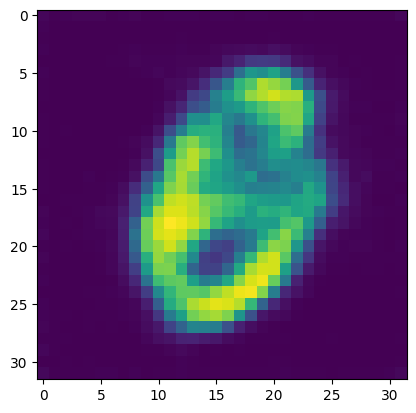

In [34]:
img, _ = vae.sample(condition=0)
plt.imshow(img.squeeze().detach().cpu())

/tmp/ipykernel_1882322/3908626686.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(F.one_hot(torch.tensor(_lab), num_classes=self.num_classes))


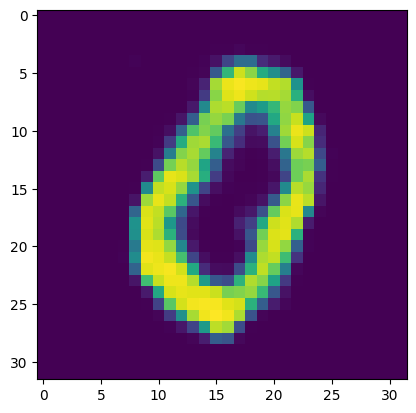

In [36]:
img, _ = gan.sample(condition=0)
plt.imshow(img.squeeze().detach().cpu())